In this notebook, the article's simulations of the default procedure is rerun and compared to the procedure using Scipy's optimization `scipy.optimize.least_square` function.

Relevant modules are first imported:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
import os 
%matplotlib inline

# Change directory to the code folder
os.chdir('..//code')

# Functions to sample the diffusion-weighted gradient directions
from dipy.core.sphere import disperse_charges, HemiSphere

# Function to reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# Functions to perform simulations based on multi-compartment models
from dipy.sims.voxel import multi_tensor

# Import Dipy's procedures to process diffusion tensor
import dipy.reconst.dti as dti

# Importing procedures to fit the free water elimination DTI model
from functions import (nls_fit_tensor, nls_fit_tensor_bounds)

Below we define the simulated acquisition parameters:

In [2]:
# Sample the spherical cordinates of 32 random diffusion-weighted
# directions.
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)

# Convert direction to cartesian coordinates. For this, Dipy's
# class object HemiSphere is used. Since diffusion possess central
# symmetric, this class object also projects the direction to an 
# Hemisphere. 
hsph_initial = HemiSphere(theta=theta, phi=phi)

# By using a electrostatic potential energy algorithm, the directions
# of the HemiSphere class object are moved util them are evenly
# distributed in the Hemi-sphere
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices

# Based on the evenly sampled directions, the acquistion parameters are
# simulated. Vector bvals containts the information of the b-values
# while matrix bvecs contains all gradient directions for all b-value repetitions.
bvals = np.hstack((np.zeros(6), 500 * np.ones(n_pts), 1500 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))

# bvals and bvecs are converted according to Dipy's accepted format using
# Dipy's function gradient_table
gtab = gradient_table(bvals, bvecs)

# The SNR is defined according to Hoy et al, 2014
SNR = 40

Next the ground truth values of tissue and water diffusion are defined:

In [3]:
# Simulations are repeated for 11 free water volume fractions
VF = np.linspace(0, 100, num=11)

# The value of free water diffusion is set to its known value 
Dwater = 3e-3

# Simulations are repeated for 5 levels of fractional anisotropy
FA = np.array([0.71, 0.30, 0.22, 0.11, 0.])
L1 = np.array([1.6e-3, 1.080e-3, 1.000e-3, 0.900e-3, 0.8e-03])
L2 = np.array([0.5e-3, 0.695e-3, 0.725e-3, 0.763e-3, 0.8e-03])
L3 = np.array([0.3e-3, 0.625e-3, 0.675e-3, 0.738e-3, 0.8e-03])

# According to Hoy et al., simulations are repeated for 120 different
# diffusion tensor directions (and each direction repeated 100 times).
nDTdirs = 120
nrep = 100

# These directions are sampled using the same procedure used
# to evenly sample the diffusion gradient directions
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices

Having all parameters set, the simulations are processed below:

In [4]:
# Initializing a matrix to save all synthetic diffusion-weighted
# signals. Each dimension of this matrix corresponds to the number
# of simulated FA levels, volume fractions, diffusion tensor
# directions, and diffusion-weighted signals of the given
# gradient table
DWI_simulates = np.empty((FA.size, VF.size, nrep * nDTdirs,
                          bvals.size))

for fa_i in range(FA.size):

    # selecting the diffusion eigenvalues for a given FA level
    mevals = np.array([[L1[fa_i], L2[fa_i], L3[fa_i]],
                       [Dwater, Dwater, Dwater]])

    for vf_i in range(VF.size):

        # estimating volume fractions for both simulations
        # compartments
        fractions = [100 - VF[vf_i], VF[vf_i]]

        for di in range(nDTdirs):

            # Select a diffusion tensor direction
            d = DTdirs[di]

            # Repeat simulations for the given directions
            for s_i in np.arange(di * nrep, (di+1) * nrep):
                # Multi-compartmental simulations are done using
                # Dipy's function multi_tensor
                signal, sticks = multi_tensor(gtab, mevals,
                                              S0=100,
                                              angles=[d, (1, 0, 0)],
                                              fractions=fractions,
                                              snr=SNR)
                DWI_simulates[fa_i, vf_i, s_i, :] = signal
    prog = (fa_i+1.0) / FA.size * 100
    time.sleep(1)
    sys.stdout.write("\r%f%%" % prog)
    sys.stdout.flush()

100.000000%

Now the we process the simulated diffusion-weigthed signals using the default article's procedure. In addition the computing time of this procedure is measured.

In [5]:
# All simulations are fitted simultaneously using function nls_fit_tensor
t0 = time.time()
fw_params = nls_fit_tensor(gtab, DWI_simulates, Diso=Dwater)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 1664.753000 seconds to run


Below we plot the results obtain from the default free water DTI fit procedure.

C:\Users\Rafael\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


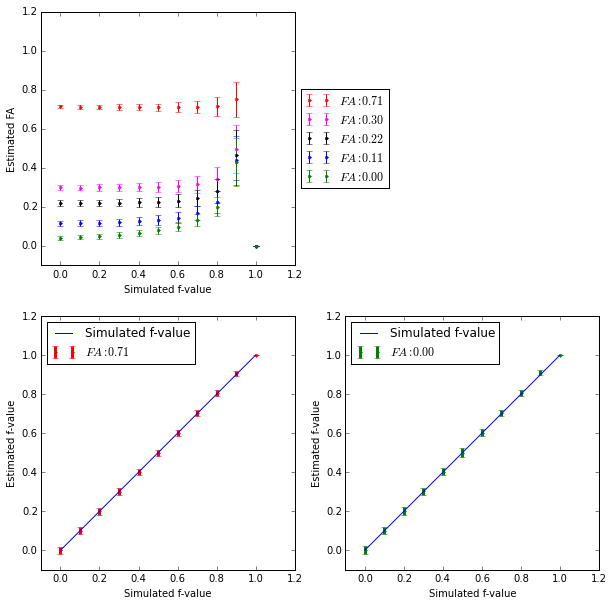

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Compute the tissue's diffusion tensor fractional anisotropy
# using function fractional_anisotropy of Dipy's module dti
fa = dti.fractional_anisotropy(fw_params[..., :3])
f = fw_params[..., 12]

# Initializing vectors for FA statistics
median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

# Defining the colors of the figure
colors = {0: 'r', 1: 'magenta', 2: 'black', 3: 'b', 4: 'g'}

for fa_i in range(FA.size):
    for vf_i in range(VF.size):

        # Compute FA statistics for a given ground truth FA
        # level and a water volume fraction
        median_fa[vf_i] = np.median(fa[fa_i, vf_i, :])
        p25, p75 = np.percentile(fa[fa_i, vf_i, :], [25, 75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        lower_p[vf_i] = p75 - median_fa[vf_i]

    # Plot FA statistics as a function of the ground truth 
    # water volume fraction
    axs[0, 0].errorbar(VF/100, median_fa, fmt='.',
                       yerr=[lower_p, lower_p],
                       color=colors[fa_i],
                       ecolor=colors[fa_i],
                       linewidth=1.0,
                       label='$FA: %.2f$' % FA[fa_i])

# Adjust properties of the first panel of the figure
axs[0, 0].set_ylim([-0.1, 1.2])
axs[0, 0].set_xlim([-0.1, 1.2])
axs[0, 0].set_xlabel('Simulated f-value')
axs[0, 0].set_ylabel('Estimated FA')
axs[0, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Turn off the upper right panel since it is not used. 
axs[0, 1].axis('off')

# Initializing vectors for volume fraction statistics
median_f = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)


for idx, fa_i in enumerate([0, 4]):
    for vf_i in range(VF.size):

        # Compute FA statistics for a given ground truth FA
        # level and a water volume fraction. Note that only
        # the extreme FA values are plotted.
        median_f[vf_i] = np.median(f[fa_i, vf_i, :])
        p25, p75 = np.percentile(f[fa_i, vf_i, :], [25, 75])
        lower_p[vf_i] = median_f[vf_i] - p25 
        lower_p[vf_i] = p75 - median_f[vf_i]

    # Plot the water volume fraction statistics as a function 
    # of its ground truth value in a lower panel of the
    # figure.
    axs[1, idx].errorbar(VF/100, median_f, fmt='.',
                         yerr=[lower_p, lower_p],
                         color=colors[fa_i],
                         ecolor=colors[fa_i],
                         linewidth=3.0,
                         label='$FA: %.2f$' % FA[fa_i])

    # plot identity lines
    axs[1, idx].plot([0, 1], [0, 1], 'b', label='Simulated f-value')
    
    # Adjust properties of a given lower panel of the figure
    axs[1, idx].legend(loc='upper left')
    axs[1, idx].set_ylim([-0.1, 1.2])
    axs[1, idx].set_xlim([-0.1, 1.2])
    axs[1, idx].set_xlabel('Simulated f-value')
    axs[1, idx].set_ylabel('Estimated f-value')

# Save figure
fig.savefig('fwdti_simulations.png')

Similar to the default free water fit procedure, the procedure using scipy's optimization `scipy.optimize.least_square` function is tested using the simulated diffusion-weighted signals and timed.

In [8]:
t0 = time.time()
fw_params = nls_fit_tensor_bounds(gtab, DWI_simulates, Diso=Dwater)
dt_bounds = time.time() - t0
print("This step took %f seconds to run" % dt_bounds)

This step took 6559.907000 seconds to run


Below we plot the results obtain from the default free water DTI fit procedure that uses the scipy's optimization scipy.optimize.least_square function.

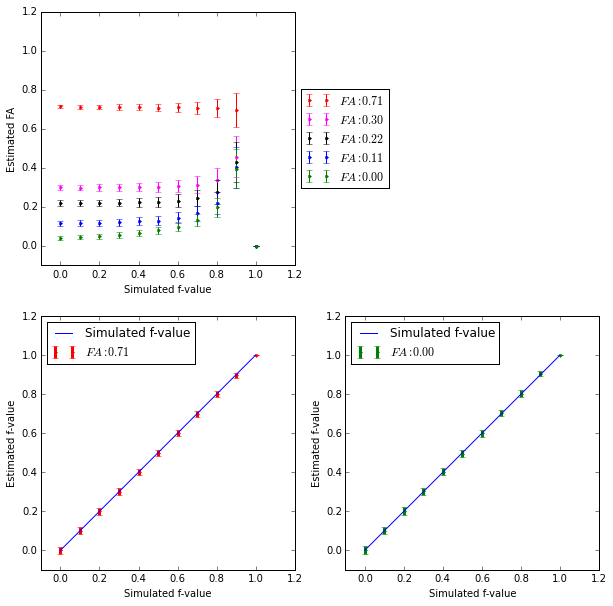

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Compute the tissue's diffusion tensor fractional anisotropy
# using function fractional_anisotropy of Dipy's module dti
fa = dti.fractional_anisotropy(fw_params[..., :3])
f = fw_params[..., 12]

# Initializing vectors for FA statistics
median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

# Defining the colors of the figure
colors = {0: 'r', 1: 'magenta', 2: 'black', 3: 'b', 4: 'g'}

for fa_i in range(FA.size):
    for vf_i in range(VF.size):

        # Compute FA statistics for a given ground truth FA
        # level and a water volume fraction
        median_fa[vf_i] = np.median(fa[fa_i, vf_i, :])
        p25, p75 = np.percentile(fa[fa_i, vf_i, :], [25, 75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        lower_p[vf_i] = p75 - median_fa[vf_i]

    # Plot FA statistics as a function of the ground truth 
    # water volume fraction
    axs[0, 0].errorbar(VF/100, median_fa, fmt='.',
                       yerr=[lower_p, lower_p],
                       color=colors[fa_i],
                       ecolor=colors[fa_i],
                       linewidth=1.0,
                       label='$FA: %.2f$' % FA[fa_i])

# Adjust properties of the first panel of the figure
axs[0, 0].set_ylim([-0.1, 1.2])
axs[0, 0].set_xlim([-0.1, 1.2])
axs[0, 0].set_xlabel('Simulated f-value')
axs[0, 0].set_ylabel('Estimated FA')
axs[0, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Turn off the upper right panel since it is not used. 
axs[0, 1].axis('off')

# Initializing vectors for volume fraction statistics
median_f = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)


for idx, fa_i in enumerate([0, 4]):
    for vf_i in range(VF.size):

        # Compute FA statistics for a given ground truth FA
        # level and a water volume fraction. Note that only
        # the extreme FA values are plotted.
        median_f[vf_i] = np.median(f[fa_i, vf_i, :])
        p25, p75 = np.percentile(f[fa_i, vf_i, :], [25, 75])
        lower_p[vf_i] = median_f[vf_i] - p25 
        lower_p[vf_i] = p75 - median_f[vf_i]

    # Plot the water volume fraction statistics as a function 
    # of its ground truth value in a lower panel of the
    # figure.
    axs[1, idx].errorbar(VF/100, median_f, fmt='.',
                         yerr=[lower_p, lower_p],
                         color=colors[fa_i],
                         ecolor=colors[fa_i],
                         linewidth=3.0,
                         label='$FA: %.2f$' % FA[fa_i])

    # plot identity lines
    axs[1, idx].plot([0, 1], [0, 1], 'b', label='Simulated f-value')
    
    # Adjust properties of a given lower panel of the figure
    axs[1, idx].legend(loc='upper left')
    axs[1, idx].set_ylim([-0.1, 1.2])
    axs[1, idx].set_xlim([-0.1, 1.2])
    axs[1, idx].set_xlabel('Simulated f-value')
    axs[1, idx].set_ylabel('Estimated f-value')

# Save figure
fig.savefig('fwdti_simulations_bounds.png')

From the figures above, one can see that both procedures have comparable performances. However the procedure using scipy's optimization scipy.optimize.least_square shows to be almost 4 times slower that the article's default procedure.

In [10]:
print(dt_bounds/dt)

3.94046864595
